# Data Preprocessing

Il dataset, prima di tutto, va opportunamente elaborato per occuparsi di eventuali dati duplicati o mancanti. Inoltre dovremo separare i dati per ottenere un training e un test set.
Gli step che seguiremo saranno i seguenti:
1. Caricare i dati
2. Gestire i dati mancanti
3. Eliminare le features ridondanti
4. Dividere il dataset in training e test set
5. Normalizzare e standardizzare i dati

## Definizione variabili

In [116]:
# Ogni input_size righe ne predico 1
input_size = 5

numero_di_features = 6
numero_nodi_nascosti = 80
numero_layers_LSTM = 3

## Caricamento dei dati

Tramite `pandas` e il dataset fornito in .csv, carichiamo i dati all'interno di un dataset.

In [117]:
import pandas as pd
import numpy as np

weather_df = pd.read_csv('files/weather_dataset.csv', sep=',')  # Loading the dataset in a Pandas Dataframe
weather_df

,wind_speed,wind_direction,temperature,dew_point,air_pressure
0,60,260,35,32,10185
1,60,260,36,33,10183
2,60,260,37,34,10181
3,50,260,38,35,10174
4,50,260,39,36,10169
...,...,...,...,...,...
70123,60,250,86,63,10301
70124,50,250,82,65,10299
70125,60,240,82,63,10291
70126,60,250,81,61,10286


## Gestione dei dati mancanti

Con un `for-each` controlliamo, per ogni colonna, quanti sono i valori mancanti.

In [118]:
for column in weather_df.columns:
  number_of_nans_in_column = weather_df[column].isnull().sum()  # Per ogni colonna, somma il numero dei valori che sono null
  print(f"{column} -> {number_of_nans_in_column} missing values")

wind_speed -> 0 missing values
wind_direction -> 0 missing values
temperature -> 0 missing values
dew_point -> 0 missing values
air_pressure -> 0 missing values


Non essendoci valori nulli, procediamo direttamente con la prossima fase.

## Eliminazione di evenutali feature ridondanti

Si mettono in `correlazione` a due a due le feature, e in caso si eliminano feature ridondanti

<AxesSubplot:>

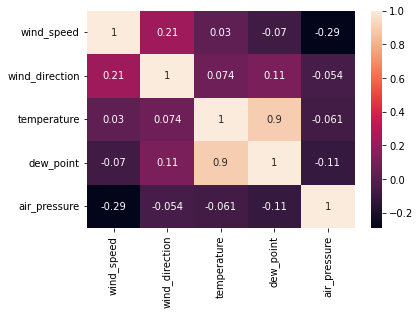

In [119]:
import seaborn as sns

correlations = weather_df.corr() # Calculating the correlations between the columns of the dataset 
sns.heatmap(correlations, annot = True)  # Displaying them in a heatmap

La temperatura e il punto di rugiada hanno una correlazione molto alta, pari a **0.9**.

Questa relazione è attribuibile alla relazione che le due feature hanno: il punto di rugiada è infatti calcolato sulla base della temperatura e dell'umidità relativa in un certo momento.
Visto che dobbiamo fare predizioni sulla temperatura, decidiamo di eliminare la feature "dew_points".

<img width="350" src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2f/Dewpoint-RH.svg/800px-Dewpoint-RH.svg.png" 
    alt="grafico_temperatura_rugiada_wikipedia" />

## Aggiunta colonna orario

In [120]:
weather_df["ora"] = list(range(0, 24)) * (int( len(weather_df) / len(range(0, 24)) ))

In [121]:
print(list(weather_df.columns))
weather_df

['wind_speed', 'wind_direction', 'temperature', 'dew_point', 'air_pressure', 'ora']


,wind_speed,wind_direction,temperature,dew_point,air_pressure,ora
0,60,260,35,32,10185,0
1,60,260,36,33,10183,1
2,60,260,37,34,10181,2
3,50,260,38,35,10174,3
4,50,260,39,36,10169,4
...,...,...,...,...,...,...
70123,60,250,86,63,10301,19
70124,50,250,82,65,10299,20
70125,60,240,82,63,10291,21
70126,60,250,81,61,10286,22


## Divisione del data set in training e test set

Si vuole dividere il data set in 3 parti:
1. Training set, comprendente tutte le righe tranne le ultime 168
2. Test set, comprendente solo le ultime 168 righe

In [122]:
training_set = weather_df[:-168]
test_set = weather_df[-168:]

## Standardizzazione e normalizzazione dei dati

Per `facilitare la fase di apprendimento` si scalano i dati del dataset.

In [123]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()

training_set_scaled = standard_scaler.fit_transform(training_set)
test_set_scaled = standard_scaler.transform(test_set)

print(f"First 3 values in training set before are:\n{training_set.head(3)}\nafter they are:\n{training_set_scaled[:3]}")
print(f"First 3 values in testing set before are:\n{test_set.head(3)}\nafter they are:\n{test_set_scaled[:3]}")

First 3 values in training set before are:
   wind_speed  wind_direction  temperature  dew_point  air_pressure  ora
0          60             260           35         32         10185    0
1          60             260           36         33         10183    1
2          60             260           37         34         10181    2
after they are:
[[ 0.8001791   0.80484909 -0.97017729 -0.6549579   0.34613392 -1.66132477]
 [ 0.8001791   0.80484909 -0.95547013 -0.63792961  0.32548664 -1.51686175]
 [ 0.8001791   0.80484909 -0.94076297 -0.62090133  0.30483935 -1.37239873]]
First 3 values in testing set before are:
       wind_speed  wind_direction  temperature  dew_point  air_pressure  ora
69960          30             250           45         24         10335    0
69961          30             250           47         27         10336    1
69962          40             260           57         26         10333    2
after they are:
[[-0.47870354  0.69544368 -0.82310569 -0.7911842   1.8946

**Questa roba qua sotto non so bene come spiegarla ma praticamente divido i due set in "roba che per fittare" e "soluzione di quello che deve predire"**

Quindi ogni 3 righe in train_x ne salvo 1 in train_y, che ipotizzo sia quella da predire
Passo successivo ripeto il procedimento traslando di 1 posizione verso l'ultima posizione l'iteratore.

In [124]:
def split_sequence(sequence, input_size):
    x, y = list(), list()

    for i in range(len(sequence)):
        end_ix = i + input_size
        
        if end_ix > len(sequence)-1:
            break
        
        # Ogni n_step volte, salva la riga dopo come l'informazione che il modello dovrà predire
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x) 
        y.append(seq_y)

    return x,y

# ogni 'input_size' righe ne predice una
input_size = 3
train_x, train_y_tutte_variabili = split_sequence(training_set_scaled, input_size)
test_x, test_y_tutte_variabili = split_sequence(test_set_scaled, input_size)

train_y_temperatura = [train_y_tutte_variabili[x][2] for x in range(len(train_y_tutte_variabili))]
test_y_temperatura = [test_y_tutte_variabili[x][2] for x in range(len(test_y_tutte_variabili))]

print(f"First values in training set before are:\n{train_x[:3]}\nafter they are:\n{train_y_temperatura[:3]}")
print(f"First values in testing set before are:\n{test_x[:3]}\nafter they are:\n{test_y_temperatura[:3]}")

First values in training set before are:
[array([[ 0.8001791 ,  0.80484909, -0.97017729, -0.6549579 ,  0.34613392,
        -1.66132477],
       [ 0.8001791 ,  0.80484909, -0.95547013, -0.63792961,  0.32548664,
        -1.51686175],
       [ 0.8001791 ,  0.80484909, -0.94076297, -0.62090133,  0.30483935,
        -1.37239873]]), array([[ 0.8001791 ,  0.80484909, -0.95547013, -0.63792961,  0.32548664,
        -1.51686175],
       [ 0.8001791 ,  0.80484909, -0.94076297, -0.62090133,  0.30483935,
        -1.37239873],
       [ 0.37388489,  0.80484909, -0.92605581, -0.60387304,  0.23257385,
        -1.2279357 ]]), array([[ 0.8001791 ,  0.80484909, -0.94076297, -0.62090133,  0.30483935,
        -1.37239873],
       [ 0.37388489,  0.80484909, -0.92605581, -0.60387304,  0.23257385,
        -1.2279357 ],
       [ 0.37388489,  0.80484909, -0.91134865, -0.58684475,  0.18095564,
        -1.08347268]])]
after they are:
[-0.9260558105515959, -0.911348650320422, -0.8525200093957265]
First values in te

Definiamo il modello di CNN che andremo ad utilizzare.

# Modello con RNN

## Definizione del modello

In [125]:
import torch

class MV_LSTM(torch.nn.Module):
    def __init__(self):
        super(MV_LSTM, self).__init__()
        self.n_features = numero_di_features
        self.n_hidden = numero_nodi_nascosti
        self.n_layers = numero_layers_LSTM
    
        self.l_lstm = torch.nn.LSTM(input_size = self.n_features, hidden_size = self.n_hidden, num_layers = self.n_layers, batch_first = True)
        self.l_linear = torch.nn.Linear(self.n_hidden * input_size, 1)
    
    def forward(self, x):        
        batch_size, seq_len, _ = x.size()
        lstm_out, self.hidden = self.l_lstm(x)
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x)

## Istanza del modello

In [126]:
import torch

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model = MV_LSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.MSELoss()
device

device(type='cpu')

## Divisione in Tensori

In [127]:
import torch
from torch.utils.data import TensorDataset

tensor_ids_train = torch.FloatTensor(train_x)
labels_train = torch.FloatTensor(train_y_temperatura)
print(tensor_ids_train.size())
print(labels_train.size())
train_dataset = TensorDataset(tensor_ids_train, labels_train)

tensor_ids_test = torch.FloatTensor(test_x)
labels_test = torch.FloatTensor(test_y_temperatura)
test_dataset = TensorDataset(tensor_ids_test, labels_test)

torch.Size([69957, 3, 6])
torch.Size([69957])


## Creazione dei DataLoader

In [128]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=False, drop_last=True)
valid_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, drop_last=True)

## Definizione di Training e Validation

In [129]:
train_losses = []
valid_losses = []

def Train(epoca):
    running_loss = .0
    
    model.train()

    # valori_previsti_lista = []
    # valori_veri_lista = []

    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        preds = model(inputs.float())
        preds = torch.squeeze(preds)
        labels = torch.squeeze(labels)

        # valori_veri_lista.append((labels.detach().numpy() * standard_scaler.scale_[2]) + standard_scaler.mean_[2])
        # valori_previsti_lista.append((preds.detach().numpy() * standard_scaler.scale_[2]) + standard_scaler.mean_[2])

        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss

    # confronto = pd.DataFrame(np.array([valori_veri_lista, valori_previsti_lista]).transpose(), index=list(range(len(valori_veri_lista))), columns=['veri', 'predetti'])
    # confronto.to_csv("files/training_epoch_" + str(epoca) + ".csv")

    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().cpu().data.numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs.float())
            preds = torch.squeeze(preds)
            labels = torch.squeeze(labels)
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().cpu().data.numpy())
        print(f'valid_loss {valid_loss}')

## Allenamento e Validazione del modello

In [130]:
epochs = 10

for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train(epoch + 1)
    Valid()

epochs 1/10
train_loss 0.12300273776054382
valid_loss 0.010563868097960949
epochs 2/10
train_loss 0.03482113778591156
valid_loss 0.008695246651768684
epochs 3/10
train_loss 0.017499472945928574
valid_loss 0.004774267319589853
epochs 4/10
train_loss 0.013960648328065872
valid_loss 0.0038925413973629475
epochs 5/10
train_loss 0.013091382570564747
valid_loss 0.0038083011750131845
epochs 6/10
train_loss 0.012790151871740818
valid_loss 0.003842403646558523
epochs 7/10
train_loss 0.012660653330385685
valid_loss 0.0038909190334379673
epochs 8/10
train_loss 0.012574337422847748
valid_loss 0.0039331912994384766
epochs 9/10
train_loss 0.012496824376285076
valid_loss 0.0039681256748735905
epochs 10/10
train_loss 0.01242009550333023
valid_loss 0.004000258632004261


## Visualizzazione grafico della loss

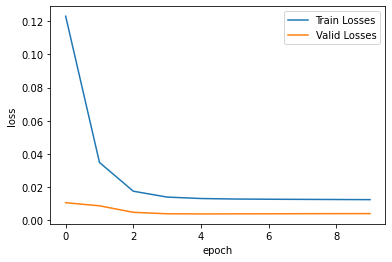

In [133]:
loss_df = pd.DataFrame( {'Train Losses':train_losses, 'Valid Losses':valid_losses }, index=list(range(len(train_losses))) )

loss_df=loss_df.astype(float)

xs = loss_df.plot()
_ = xs.set_ylabel("loss")
_ = xs.set_xlabel("epoch")

## Salva stato del modello

In [132]:
torch.save(model.state_dict(), 'files/saved_state_of_model.pth')

## Carica stato del modello

In [ ]:
model.load_state_dict(torch.load('files/saved_state_of_model.pth'))

# Predizione e valutazione del modello

## Previsione ricorsiva del modello

In [134]:
valori_veri_lista = []
valori_veri_lista.append((test_set_scaled[:,2] * standard_scaler.scale_[2]) + standard_scaler.mean_[2])

In [135]:
from math import sqrt
from torch import nn
from array import array

evalutation_loss = nn.MSELoss()

last_3_rows_training = [training_set_scaled[-3:]]

def evaluate_model(model, first_input, test):
	predictions = list()
	input = first_input

	prima_predizione = model(torch.FloatTensor(input))
	prima_predizione = torch.squeeze(prima_predizione).cpu().detach().numpy().tolist()
	predictions.append(prima_predizione)

	test_set_scaled[0,2] = prima_predizione
	input = [np.delete( np.append(input[0], [test_set_scaled[0]], axis=0), 0, 0)]

	for i in range(len(test) - 1):

		with torch.no_grad():
			predizione = model(torch.FloatTensor(input))
			predizione = torch.squeeze(predizione).cpu().detach().numpy().tolist()

			test_set_scaled[1 + i,2] = predizione

			input = [np.delete( np.append(input[0], [test_set_scaled[1 + i]], axis=0), 0, 0)]
			predictions.append(predizione)
	return predictions

recursive_pred = evaluate_model(model, last_3_rows_training, test_set_scaled)

## Valutazione del modello

Hidden layers in LSTM 3
Nodes in layer 80


<AxesSubplot:>

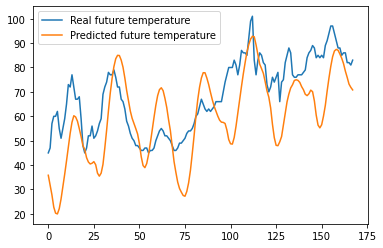

In [136]:
valori_previsti_lista = []

valori_previsti_lista.append((np.float64(recursive_pred) * standard_scaler.scale_[2]) + standard_scaler.mean_[2])

result = pd.DataFrame({'Real future temperature':valori_veri_lista[0], 'Predicted future temperature':valori_previsti_lista[0] }, index=list(range(len(valori_veri_lista[0]))))

print("Hidden layers in LSTM", model.n_layers)
print("Nodes in layer", model.n_hidden)
result.plot()